In [1]:
import os

os.chdir('/mnt/jw01-aruk-home01/projects/ra_challenge/RA_challenge/michael_dev/RA2_alpine_lads/ra_joint_predictions')

In [2]:
from utils.config import Config

config = Config()

In [3]:
from dataset.joint_damage_type_dataset import joint_damage_type_dataset
from dataset.joints.joint_extractor import default_joint_extractor, feet_joint_extractor, width_based_joint_extractor
from dataset.joints.joint_extractor_factory import get_joint_extractor

hands_narrowing = joint_damage_type_dataset(config, joint_extractor = get_joint_extractor('H', False), repeat_test = False)
hands_erosion = joint_damage_type_dataset(config, joint_extractor = get_joint_extractor('H', True), repeat_test = False)
feet_narrowing = joint_damage_type_dataset(config, joint_extractor = get_joint_extractor('F', False), repeat_test = False)
feet_erosion = joint_damage_type_dataset(config, joint_extractor = get_joint_extractor('F', True), repeat_test = False)
combined_narrowing = joint_damage_type_dataset(config, joint_extractor = get_joint_extractor('HF', False))

tf_hands_j_data = hands_narrowing.get_hands_joint_damage_type_dataset_with_validation(config.train_location + '/training.csv', erosion_flag = False)
tf_hands_e_data = hands_erosion.get_hands_joint_damage_type_dataset_with_validation(config.train_location + '/training.csv', erosion_flag = True)
tf_feet_j_data = feet_narrowing.get_feet_joint_damage_type_dataset_with_validation(config.train_location + '/training.csv', erosion_flag = False)
tf_feet_e_data = feet_erosion.get_feet_joint_damage_type_dataset_with_validation(config.train_location + '/training.csv', erosion_flag = True)

2020-05-10 14:53:10,371;WARNING - Missing permissions to create directory for caching!
2020-05-10 14:53:15,515;WARNING - Missing permissions to create directory for caching!
2020-05-10 14:53:17,176;WARNING - Missing permissions to create directory for caching!
2020-05-10 14:53:18,419;WARNING - Missing permissions to create directory for caching!


In [4]:
import numpy as np

print(np.unique(hands_narrowing.outcomes, return_counts = True))

(array([0., 1., 2., 3., 4.]), array([4093,  296,  287,  143,  149]))


In [5]:
import numpy as np

print(np.unique(hands_erosion.outcomes, return_counts = True))

(array([0., 1., 2., 3., 4., 5.]), array([5085,  213,  138,   43,   14,   27]))


In [6]:
import numpy as np

print(np.unique(feet_narrowing.outcomes, return_counts = True))

(array([0., 1., 2., 3., 4.]), array([2792,   73,  248,  107,   92]))


In [7]:
import numpy as np

print(np.unique(feet_erosion.outcomes, return_counts = True))

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]), array([2802,  120,  161,   92,   40,   44,   11,   14,   11,    8,    9]))


In [8]:
import tensorflow.keras as keras

j_model = keras.models.load_model('../trained_models/narrowing/v7/narrowing_joint_damage_type_model_complex_rewritten_64bs_normsteps_75epochs_adamW_3e4_1e6.h5', compile = False)
j_model_gamma1 = keras.models.load_model('../trained_models/narrowing/v7/narrowing_joint_damage_type_model_complex_rewritten_64bs_normsteps_75epochs_adamW_3e4_1e6_gamma1.h5', compile = False)

e_model = keras.models.load_model('../trained_models/erosion/v7/narrowing_joint_damage_type_model_complex_rewritten_64bs_normsteps_75epochs_adamW_3e4_1e6.h5', compile = False)
e_model_gamma1 = keras.models.load_model('../trained_models/erosion/v7/narrowing_joint_damage_type_model_complex_rewritten_64bs_normsteps_75epochs_adamW_3e4_1e6_gamma1.h5', compile = False)

hands_j_mixed_c = keras.models.load_model('../trained_models/narrowing/v7/hands_narrowing_joint_damage_type_model_complex_rewritten_64bs_normsteps_75epochs_adamW_3e4_1e6_mixed_test_calpha.h5', compile = False)
hands_j_mixed_gamma_1 = keras.models.load_model('../trained_models/narrowing/v7/hands_narrowing_joint_damage_type_model_complex_rewritten_64bs_normsteps_75epochs_adamW_3e4_1e6_test_gamma1.h5', compile = False)

feet_j_mixed_c = keras.models.load_model('../trained_models/narrowing/v7/feet_narrowing_joint_damage_type_model_complex_rewritten_64bs_normsteps_75epochs_adamW_3e4_1e6_mixed_test_calpha.h5', compile = False)
feet_j_mixed_gamma_1 = keras.models.load_model('../trained_models/narrowing/v7/feet_narrowing_joint_damage_type_model_complex_rewritten_64bs_normsteps_75epochs_adamW_3e4_1e6_test_gamma1.h5', compile = False)

hands_e_mixed_c = keras.models.load_model('../trained_models/erosion/v7/hands_erosion_joint_damage_type_model_complex_rewritten_64bs_normsteps_75epochs_adamW_3e4_1e6_mixed_test_calpha.h5', compile = False)
hands_e_mixed_gamma_1 = keras.models.load_model('../trained_models/erosion/v7/hands_erosion_joint_damage_type_model_complex_rewritten_64bs_normsteps_75epochs_adamW_3e4_1e6_test_gamma1.h5', compile = False)

feet_e_mixed_c = keras.models.load_model('../trained_models/erosion/v7/feet_erosion_joint_damage_type_model_complex_rewritten_64bs_normsteps_75epochs_adamW_3e4_1e6_mixed_test_calpha.h5', compile = False)
feet_e_mixed_gamma_1 = keras.models.load_model('../trained_models/erosion/v7/feet_erosion_joint_damage_type_model_complex_rewritten_64bs_normsteps_75epochs_adamW_3e4_1e6_test_gamma1.h5', compile = False)

In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt

def print_metrics(models, ds, title, cutoff = 0.5):
    truths = []
    preds = []

    for x, y in ds[1]:
        y_pred = models[0].predict(x)[:, 0]
        
        for model in models[1:]:
            y_pred += model.predict(x)[:, 0]
            
        y_pred = y_pred / len(models)
    
        truths.extend(y.numpy())
        preds.extend(y_pred)
    
    truths = np.array(truths)
    preds = np.array(preds)
    
    print('Brier', np.mean(np.square(truths - preds)))
    print('AUC', roc_auc_score(truths, preds))

    precs_0 = []
    recs_0 = []
    recs_1 = []
    
    cutoffs = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
    
    rows = []
    
    for n in cutoffs:
        c_preds = np.zeros(preds.shape[0])
        c_preds[preds > n] = 1

        report = classification_report(truths, c_preds, output_dict = True)
        prec_0 = report['0.0']['precision']
        rec_0 = report['0.0']['recall']
        rec_1 = report['1.0']['recall']  
          
        precs_0.append(prec_0)
        recs_0.append(rec_0)
        recs_1.append(rec_1)
        
        rows.append({
            'cutoff': n,
            'prec_0': prec_0,
            'rec_0': rec_0,
            'rec_1': rec_1
            
        })
        
    plt.figure(figsize = (6, 4))
    plt.plot(cutoffs, precs_0, label = 'Precision 0')
    plt.plot(cutoffs, recs_0, label = 'Recall_0')
    plt.plot(cutoffs, recs_1, label = 'Recall 1')
    plt.plot([cutoff, cutoff], [0, 1])
    plt.grid()
    plt.title(title)
    plt.legend()
    plt.show()
    
    return pd.DataFrame(rows, index = np.arange(len(rows)))

Brier 0.059166977048824856
AUC 0.9443518263180325


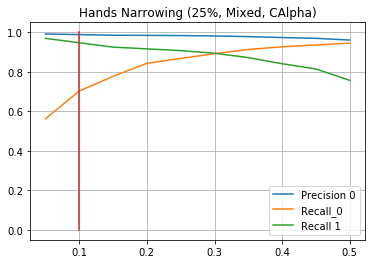

,cutoff,prec_0,rec_0,rec_1
0,0.05,0.991261,0.562323,0.969027
1,0.10,0.988048,0.702550,0.946903
2,0.15,0.984740,0.776912,0.924779
3,0.20,0.984285,0.842776,0.915929
4,0.25,0.983146,0.867564,0.907080
5,0.30,0.981294,0.891643,0.893805
6,0.35,0.977997,0.912890,0.871681
7,0.40,0.973214,0.926346,0.840708
8,0.45,0.969186,0.935552,0.814159
9,0.50,0.960403,0.944759,0.756637


In [30]:
print_metrics([hands_j_mixed_c], tf_hands_j_data, 'Hands Narrowing (25%, Mixed, CAlpha)', cutoff = 0.1)

Brier 0.060663353442143575
AUC 0.9526623881270526


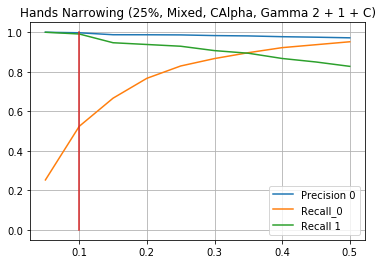

,cutoff,prec_0,rec_0,rec_1
0,0.05,1.000000,0.252833,1.000000
1,0.10,0.997305,0.524079,0.991150
2,0.15,0.987408,0.666431,0.946903
3,0.20,0.987238,0.766997,0.938053
4,0.25,0.986521,0.829320,0.929204
5,0.30,0.983133,0.866856,0.907080
6,0.35,0.981395,0.896601,0.893805
7,0.40,0.977477,0.922096,0.867257
8,0.45,0.974945,0.936969,0.849558
9,0.50,0.971800,0.951841,0.827434


In [10]:
print_metrics([hands_j_mixed_c, hands_j_mixed_gamma_1, j_model], tf_hands_j_data, 'Hands Narrowing (25%, Mixed, CAlpha, Gamma 2 + 1 + C)', cutoff = 0.1)

Brier 0.06583524285194879
AUC 0.9482134452121262


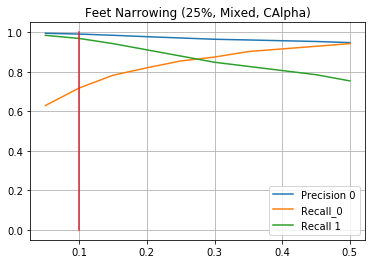

,cutoff,prec_0,rec_0,rec_1
0,0.05,0.994737,0.629301,0.984293
1,0.10,0.990812,0.718091,0.968586
2,0.15,0.984637,0.782464,0.942408
3,0.20,0.977513,0.820200,0.910995
4,0.25,0.970996,0.854606,0.879581
5,0.30,0.964504,0.874584,0.848168
6,0.35,0.960993,0.902331,0.827225
7,0.40,0.957077,0.915649,0.806283
8,0.45,0.953303,0.928968,0.785340
9,0.50,0.947545,0.942286,0.753927


In [32]:
print_metrics([feet_j_mixed_c], tf_feet_j_data, 'Feet Narrowing (25%, Mixed, CAlpha)', cutoff = 0.1)

Brier 0.05840799348871208
AUC 0.9549714976378777


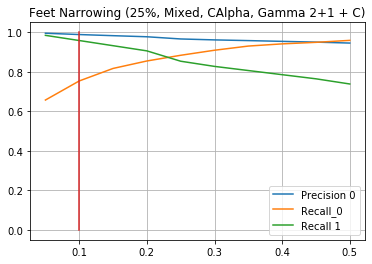

,cutoff,prec_0,rec_0,rec_1
0,0.05,0.994958,0.657048,0.984293
1,0.10,0.988355,0.753607,0.958115
2,0.15,0.982644,0.816870,0.931937
3,0.20,0.977157,0.854606,0.905759
4,0.25,0.966019,0.883463,0.853403
5,0.30,0.961268,0.908990,0.827225
6,0.35,0.957714,0.930078,0.806283
7,0.40,0.953881,0.941176,0.785340
8,0.45,0.950000,0.948946,0.764398
9,0.50,0.945295,0.958935,0.738220


In [13]:
print_metrics([feet_j_mixed_c, feet_j_mixed_gamma_1, j_model], tf_feet_j_data, 'Feet Narrowing (25%, Mixed, CAlpha, Gamma 2+1 + C)', cutoff = 0.1)

Brier 0.06462386518534505
AUC 0.8833997906301092


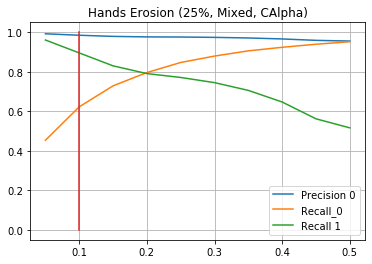

,cutoff,prec_0,rec_0,rec_1
0,0.05,0.992126,0.453509,0.960784
1,0.10,0.984820,0.622675,0.895425
2,0.15,0.979049,0.728854,0.830065
3,0.20,0.976453,0.796041,0.790850
4,0.25,0.975812,0.847031,0.771242
5,0.30,0.974086,0.879424,0.745098
6,0.35,0.971061,0.905819,0.705882
7,0.40,0.966123,0.923815,0.647059
8,0.45,0.958971,0.939412,0.562092
9,0.50,0.955449,0.952010,0.516340


In [35]:
print_metrics([hands_e_mixed_c], tf_hands_e_data, 'Hands Erosion (25%, Mixed, CAlpha)', cutoff = 0.1)

Brier 0.057576102155195555
AUC 0.9022156353043116


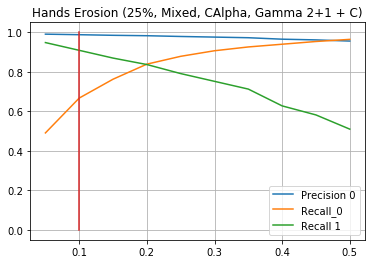

,cutoff,prec_0,rec_0,rec_1
0,0.05,0.990315,0.490702,0.947712
1,0.10,0.987567,0.667067,0.908497
2,0.15,0.984508,0.762448,0.869281
3,0.20,0.982431,0.838632,0.836601
4,0.25,0.978610,0.878224,0.790850
5,0.30,0.975468,0.906419,0.751634
6,0.35,0.972275,0.925615,0.712418
7,0.40,0.964880,0.939412,0.627451
8,0.45,0.961283,0.953209,0.581699
9,0.50,0.955410,0.964007,0.509804


In [15]:
print_metrics([hands_e_mixed_c, hands_e_mixed_gamma_1, e_model], tf_hands_e_data, 'Hands Erosion (25%, Mixed, CAlpha, Gamma 2+1 + C)', cutoff = 0.1)

Brier 0.11022390311225366
AUC 0.8698183479633375


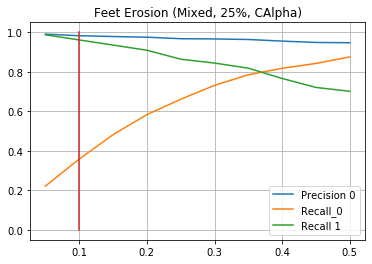

,cutoff,prec_0,rec_0,rec_1
0,0.05,0.990476,0.221748,0.987013
1,0.10,0.982456,0.358209,0.961039
2,0.15,0.978355,0.481876,0.935065
3,0.20,0.975045,0.583156,0.909091
4,0.25,0.967239,0.660981,0.863636
5,0.30,0.966197,0.731343,0.844156
6,0.35,0.963351,0.784648,0.818182
7,0.40,0.955168,0.817697,0.766234
8,0.45,0.948379,0.842217,0.720779
9,0.50,0.946943,0.875267,0.701299


In [36]:
print_metrics([feet_e_mixed_c], tf_feet_e_data, 'Feet Erosion (Mixed, 25%, CAlpha)', cutoff = 0.1)

Brier 0.09345604305925431
AUC 0.8894373217400937


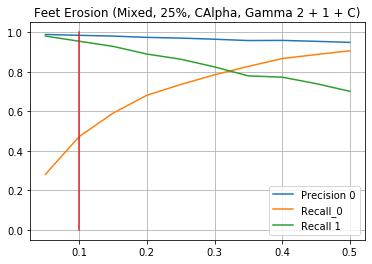

,cutoff,prec_0,rec_0,rec_1
0,0.05,0.988764,0.281450,0.980519
1,0.10,0.984444,0.472281,0.954545
2,0.15,0.980531,0.590618,0.928571
3,0.20,0.974085,0.681237,0.889610
4,0.25,0.970464,0.735608,0.863636
5,0.30,0.964613,0.784648,0.824675
6,0.35,0.958025,0.827292,0.779221
7,0.40,0.958726,0.866738,0.772727
8,0.45,0.954128,0.886994,0.740260
9,0.50,0.948661,0.906183,0.701299


In [17]:
print_metrics([feet_e_mixed_c, feet_e_mixed_gamma_1, e_model], tf_feet_e_data, 'Feet Erosion (Mixed, 25%, CAlpha, Gamma 2 + 1 + C)', cutoff = 0.1)